In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words

words = open('./data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary

chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset + train/dev/test split

block_size = 3 # context length

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [6]:
# MLP revisited

n_embd = 10 # the dim of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the character into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i: 7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8050
  20000/ 200000: 2.5518
  30000/ 200000: 2.8035
  40000/ 200000: 2.0476
  50000/ 200000: 2.7033
  60000/ 200000: 2.3179
  70000/ 200000: 2.0966
  80000/ 200000: 2.3344
  90000/ 200000: 2.2155
 100000/ 200000: 2.0712
 110000/ 200000: 2.4086
 120000/ 200000: 1.8661
 130000/ 200000: 2.3103
 140000/ 200000: 2.2350
 150000/ 200000: 2.1742
 160000/ 200000: 2.1190
 170000/ 200000: 1.7579
 180000/ 200000: 2.0183
 190000/ 200000: 1.8186


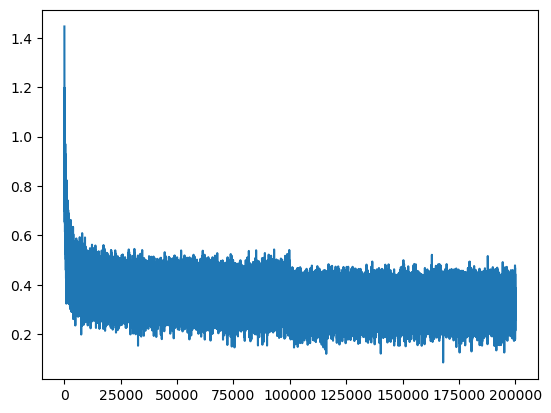

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1256532669067383
val 2.1684703826904297


In [11]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the NN
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special token - break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carlah.
amille.
khy.
mili.
taty.
skanden.
jazonen.
den.
art.
kaqui.
nextara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearyn.
kai.


# Loss at Initialization

When we init out NN with random weights the loss is too high. Usually we can guess the loss value which we want to get as a result, so we can start training our NN with "better" weights.

In [12]:
-torch.tensor(1/27.0).log() # 1/27.0 - this a probability of each character assumed we have a uniform distribution

tensor(3.2958)

In [13]:
# so 3.2958 - our tartget initialization loss

In [14]:
# 4-dimensional example of the issue (look at loss)

logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [15]:
# 4-dimensional example of the issue (look at loss)

logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]), tensor(5.0553))

## We want our logits to be ~0.0 when we initalize out network

# Lets reinit our NN to achive this

In [16]:
# MLP revisited

n_embd = 10 # the dim of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1 # we scale down out weights (they influence on our logits)
b2 = torch.randn(vocab_size, generator=g) * 0 # we zero down out bias (it influences on our logits)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [17]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the character into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i: 7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 4.2326
  10000/ 200000: 2.1403
  20000/ 200000: 2.4720
  30000/ 200000: 2.5577
  40000/ 200000: 2.0154
  50000/ 200000: 2.4307
  60000/ 200000: 2.3385
  70000/ 200000: 2.0680
  80000/ 200000: 2.2665
  90000/ 200000: 2.1172
 100000/ 200000: 1.9299
 110000/ 200000: 2.0630
 120000/ 200000: 1.8901
 130000/ 200000: 2.3980
 140000/ 200000: 2.2826
 150000/ 200000: 2.1250
 160000/ 200000: 1.8469
 170000/ 200000: 1.7628
 180000/ 200000: 1.9119
 190000/ 200000: 1.8235


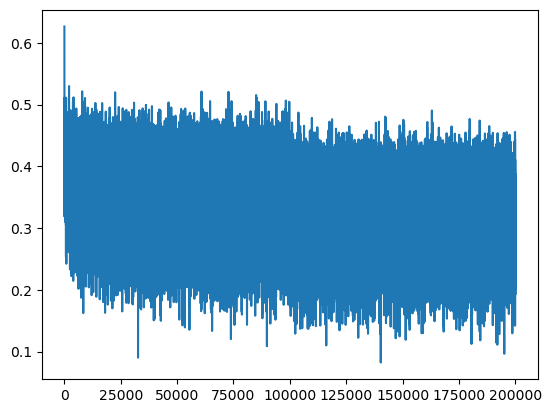

In [18]:
plt.plot(lossi)

# Now we see that our loss at the first iteration is not so high.

In [19]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0681495666503906
val 2.132511854171753


### We get better validation loss because we spend more iterations on real training, not squashing down the weights

# Fix the saturated tanh

In [20]:
# MLP revisited

n_embd = 10 # the dim of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1 # we scale down out weights (they influence on our logits)
b2 = torch.randn(vocab_size, generator=g) * 0 # we zero down out bias (it influences on our logits)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


### Let's break after the first iteration

In [21]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the character into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i: 7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 4.2326


In [23]:
# THe problem is the values of h

h # too many -1 and 1 values

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

In [24]:
h.shape

torch.Size([32, 200])

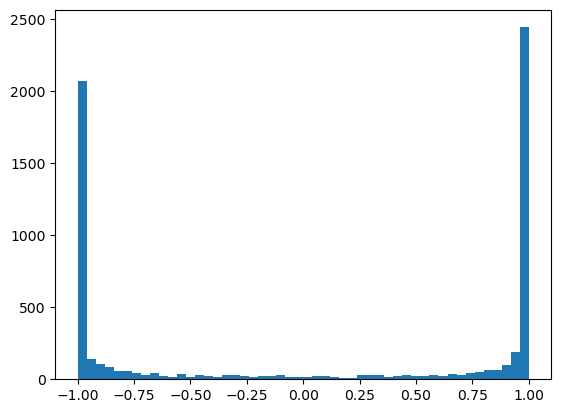

In [25]:
plt.hist(h.view(-1).tolist(), 50);

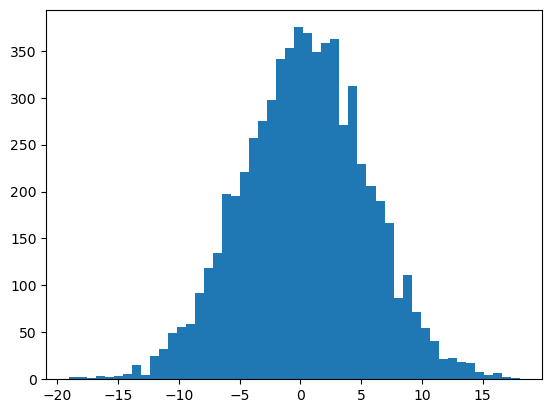

In [26]:
# let's look at out preactivation values

plt.hist(hpreact.view(-1).tolist(), 50); # it's very broad 

### When we will propagate over the Tanh, we will calculate tha gradient as (1 - t**2). It means that if our t is -1 or 1, our gradient will be zero. If out gradient, we don't change weight during the update and our NN stop training.

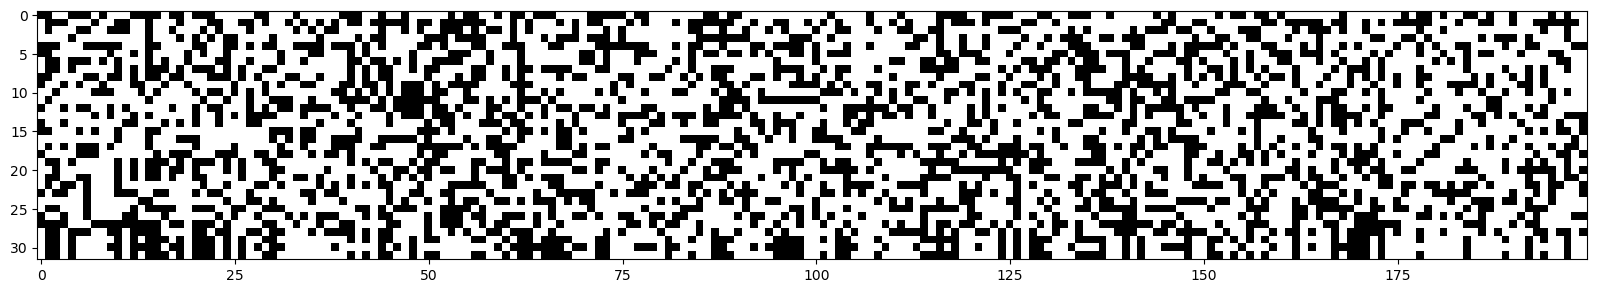

In [27]:
# let's visualize our "dead" neurons (the whole column should be white)

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
# Sigmoid, ReLu have the same issue
# It's fixed in Leaky ReLU

### To fix it, we reinit our NN with other weights

In [28]:
# MLP revisited

n_embd = 10 # the dim of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # we scale down out weights (they influence on our logits)
b2 = torch.randn(vocab_size, generator=g) * 0 # we zero down out bias (it influences on our logits)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [29]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the character into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i: 7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.3069


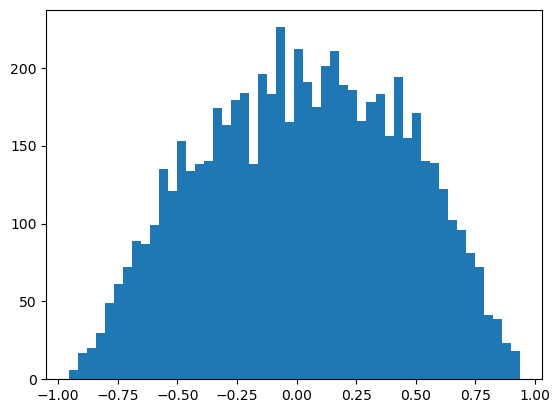

In [30]:
plt.hist(h.view(-1).tolist(), 50);

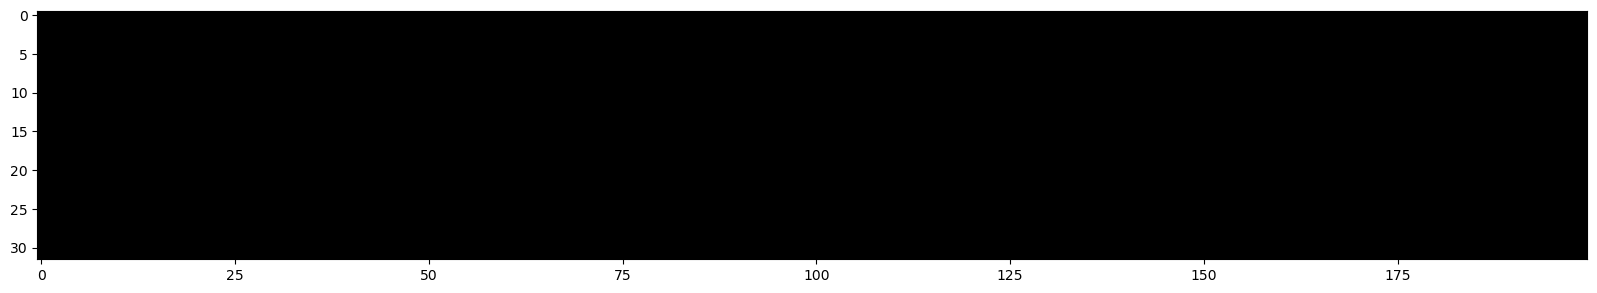

In [31]:
# let's visualize our "dead" neurons (the whole column should be white)

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# Yay! No white at all

In [32]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the character into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i: 7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2698
  10000/ 200000: 1.9368
  20000/ 200000: 1.9634
  30000/ 200000: 2.0628
  40000/ 200000: 2.2200
  50000/ 200000: 2.1126
  60000/ 200000: 2.0831
  70000/ 200000: 2.3918
  80000/ 200000: 2.5420
  90000/ 200000: 2.1891
 100000/ 200000: 2.1510
 110000/ 200000: 1.8409
 120000/ 200000: 2.1879
 130000/ 200000: 1.9402
 140000/ 200000: 1.8094
 150000/ 200000: 2.4544
 160000/ 200000: 2.1762
 170000/ 200000: 1.7701
 180000/ 200000: 1.8874
 190000/ 200000: 2.0942


In [33]:
# and we got better validation loss

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0579612255096436
val 2.1137912273406982


# But we don't want to set these scales by hands. We actually have an approach how to choose them.

tensor(-0.0009) tensor(1.0055)
tensor(0.0086) tensor(3.1362)


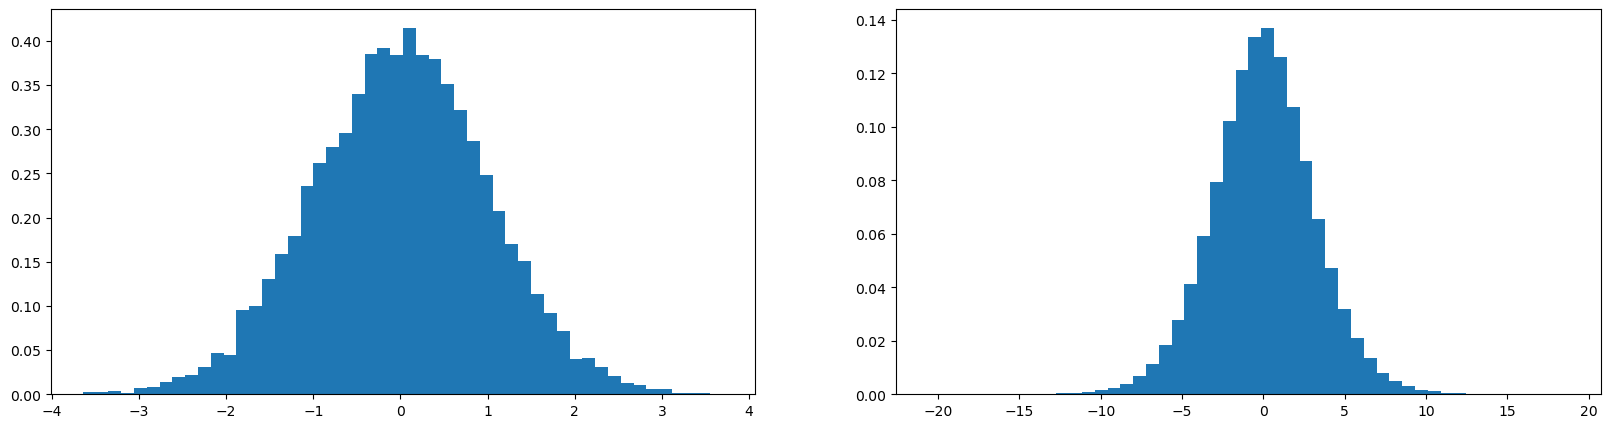

In [41]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].hist(x.view(-1).tolist(), 50, density=True)
ax[1].hist(y.view(-1).tolist(), 50, density=True)
plt.show()

# we want to scale w the way it would preserve a gaussian distribution (as x)

tensor(0.0032) tensor(0.9989)
tensor(-0.0016) tensor(0.9885)


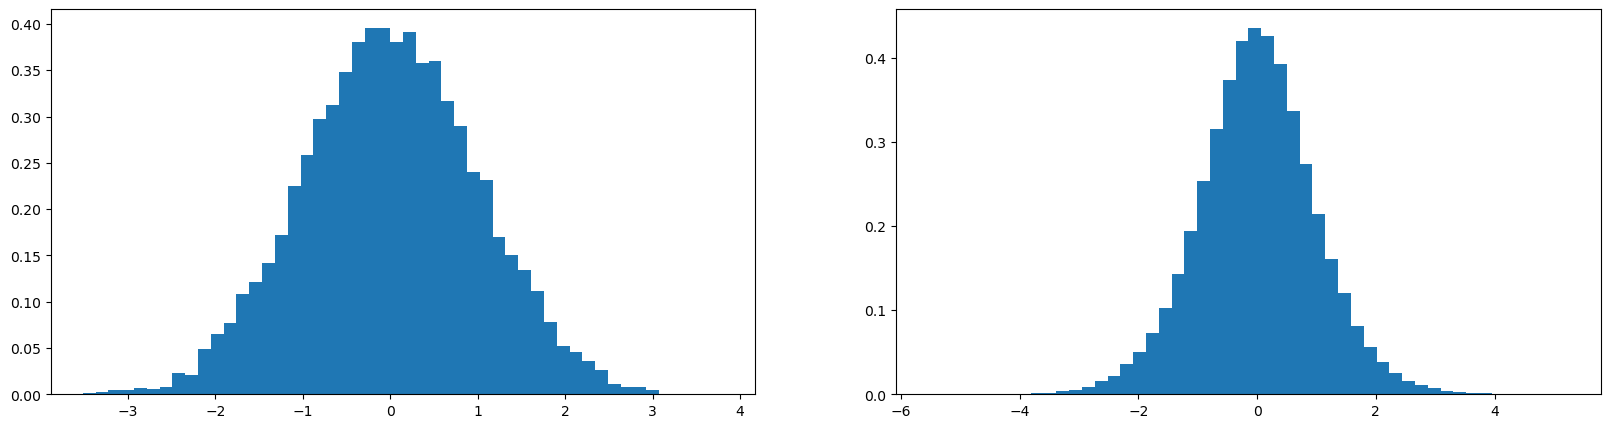

In [43]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 # dividing by the square root of the fan_in (number of inputs), this is Kaiman init
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].hist(x.view(-1).tolist(), 50, density=True)
ax[1].hist(y.view(-1).tolist(), 50, density=True)
plt.show()

# we need need to devide weights by the square root of number_of_inputs (fan_in in pytorch) (in our case 10)

# This is called Kaimin init (there is a function in pyTorch)

# We don't need to be so careful with initialization anymore, because we have BatchNorm, LayerNorm, Redisual Connections, Better Optimizers (RMSprop, Adam). But using Kaimin init - is a perfect strategy to be safe.

# Let's init our NN one more time

In [44]:
# MLP revisited

n_embd = 10 # the dim of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # Kaimin init
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # we scale down out weights (they influence on our logits)
b2 = torch.randn(vocab_size, generator=g) * 0 # we zero down out bias (it influences on our logits)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [45]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the character into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i: 7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


In [46]:
# and we got better validation loss

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


# Batch Normalization

### The idea is that if we want our weights to be Gaussian distributed we can just normalize them when we forward-pass it

In [65]:
# MLP revisited

n_embd = 10 # the dim of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # Kaimin init
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # we scale down out weights (they influence on our logits)
b2 = torch.randn(vocab_size, generator=g) * 0 # we zero down out bias (it influences on our logits)

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [66]:
hpreact.shape

torch.Size([32, 200])

In [67]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [68]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [69]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the character into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # Batch Normalization!!!
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i: 7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [72]:
# and we got better validation loss

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # Batch Normalization!!!
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104844808578491


# The problem of a Batch Normalization is that it transforms matematically examples in a Batch. That kinda makes examples in different batches transformed different ways. On one hand it has a good side-effect that it brings a regularization to our network (due to the noize in our inputs), but on the other hand it makes it less deterministic. So we want to fix it. We can do it with Layer Normalization.

# But BatchNorm performs really well

# How do we feed a single example and get sensible result out?

# We need to calibrate the batch norm at the end of training

In [73]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [74]:
# and we got better validation loss

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # Batch Normalization!!!
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.1049270629882812


# Now we can inference a single example

# But we can estimate it in a running matter while we train out network. This will allow us to avoid the second step. (No one likes extra steps)

# Tip: if you add a BatchNorm layer after some linear layer, you can remove Bias from it, because it won't affect anything (just think about how normalization works).

In [86]:
# MLP revisited

n_embd = 10 # the dim of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # Kaimin init
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # we scale down out weights (they influence on our logits)
b2 = torch.randn(vocab_size, generator=g) * 0 # we zero down out bias (it influences on our logits)

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, 
    #b1, 
    W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [87]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the character into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors

    # Linear Layer -----------------------------------

    hpreact = embcat @ W1 # + b1 # hidden layer preactivation

    # BatchNorm Layer --------------------------------

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # Batch Normalization!!!

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # Non-linearity ------------------------------------

    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i: 7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


In [88]:
# we do it just to compare our results of running estimation with the second-step results (it should be very close)

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [89]:
bnmean

tensor([[-2.4155e+00,  3.5980e-01, -1.2714e+00,  1.3146e+00,  9.5401e-01,
          1.0053e+00,  1.5467e+00, -1.9309e+00,  1.1036e+00,  1.2525e+00,
         -1.7996e+00, -2.7801e+00,  7.5269e-02, -5.8463e-01,  4.4472e-01,
         -6.8417e-01,  7.7318e-01, -2.1998e+00, -2.1400e-01,  1.6026e+00,
         -8.8026e-01,  9.7818e-02, -2.4424e-01,  4.0673e-01,  1.0444e+00,
          1.6453e+00,  1.2090e+00,  9.5449e-01,  3.6648e-01,  1.9436e+00,
         -6.5974e-02, -1.2044e+00, -1.0077e-01, -2.8142e-01, -4.8431e-01,
         -1.5074e+00, -2.6169e+00,  5.4709e-02, -1.5000e-03,  6.1692e-01,
         -2.2766e-01, -8.9404e-01, -2.7207e-01, -2.0177e-01,  6.4714e-01,
          8.9469e-01,  1.5835e+00, -3.9380e-01,  1.9980e+00,  1.0549e+00,
          1.7120e+00, -7.9726e-01,  2.0453e+00,  3.6367e-01,  5.4204e-01,
         -1.9238e+00, -2.0423e-02,  7.3257e-01,  9.0093e-01, -7.7813e-01,
         -6.6497e-01,  9.7269e-01,  4.9276e-01,  2.9063e-01,  1.1454e+00,
          1.6409e+00, -1.3144e+00,  2.

In [90]:
bnmean_running

tensor([[-2.4073e+00,  3.7331e-01, -1.2681e+00,  1.2967e+00,  9.6879e-01,
          9.8374e-01,  1.5422e+00, -1.9247e+00,  1.1060e+00,  1.2247e+00,
         -1.8296e+00, -2.7717e+00,  7.1382e-02, -6.1822e-01,  4.3366e-01,
         -6.6874e-01,  7.7062e-01, -2.1880e+00, -2.1888e-01,  1.5706e+00,
         -8.6629e-01,  1.0769e-01, -2.3912e-01,  4.1434e-01,  1.0355e+00,
          1.6324e+00,  1.1980e+00,  9.5800e-01,  3.5302e-01,  1.9480e+00,
         -8.0373e-02, -1.2021e+00, -9.8016e-02, -2.6651e-01, -4.7077e-01,
         -1.4911e+00, -2.6119e+00,  4.6961e-02, -2.9913e-04,  6.0432e-01,
         -2.3634e-01, -9.1243e-01, -2.8294e-01, -1.7834e-01,  6.5023e-01,
          9.0387e-01,  1.5864e+00, -3.9490e-01,  1.9726e+00,  1.0563e+00,
          1.7167e+00, -7.9533e-01,  2.0450e+00,  3.5585e-01,  5.4984e-01,
         -1.9198e+00, -3.1753e-02,  7.1274e-01,  9.0174e-01, -7.9930e-01,
         -6.7666e-01,  9.6929e-01,  4.8910e-01,  2.9598e-01,  1.1424e+00,
          1.6292e+00, -1.3298e+00,  2.

In [91]:
# it is very close (it shouldn't be identical)

In [92]:
# and we got better validation loss

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # Batch Normalization!!!
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # actually bnbias handles needed bias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674192905426025
val 2.105670690536499
